# Init

In [1]:
!pip install nltk
!python -m nltk.downloader stopwords

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.8/792.8 kB 10.0 MB/s eta 0:00:0000:0100:01
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import seaborn as sns
import re

In [4]:
df = pd.read_csv('anthems.csv')
df = df[['Anthem']]

In [5]:
df['Anthem'] = df['Anthem'].str.lower()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

df['Anthem_Cleaned'] = df['Anthem'].apply(clean_text)

# 1. Aplique as transformações necessárias ao campo hino. (TF, TFIDF, etc).

In [6]:
vectorizer = TfidfVectorizer(min_df=5, max_features=1500)
tfidf_matrix = vectorizer.fit_transform(df['Anthem_Cleaned'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 2. Aplique o Kmeans para tentar encontrar grupos semelhantes de hinos.

In [10]:
n_kmeans = 5
kmeans = KMeans(n_clusters=n_kmeans, random_state=42)
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=5, random_state=42)

In [11]:
df['KMeans_Cluster'] = kmeans.labels_
tsne = TSNE(n_components=2, random_state=42, init='random', perplexity=30) # utilizando TSNE para reduzir dimensionalidade e plotar grafico
kmeans_tsne = tsne.fit_transform(tfidf_matrix)

In [12]:
df.head()

,Anthem,Anthem_Cleaned,KMeans_Cluster
0,"around our flag we stand united, with one wish...",around flag stand united one wish one goal sac...,1
1,"our fatherland, free, independent, that has fo...",fatherland free independent centuries lived su...,3
2,"land of mountains, land by the river, land of ...",land mountains land river land fields land cat...,3
3,"azerbaijan, azerbaijan! the glorious fatherlan...",azerbaijan azerbaijan glorious fatherland valo...,4
4,"we, belarusians, are peaceful people, wholehea...",belarusians peaceful people wholeheartedly dev...,1


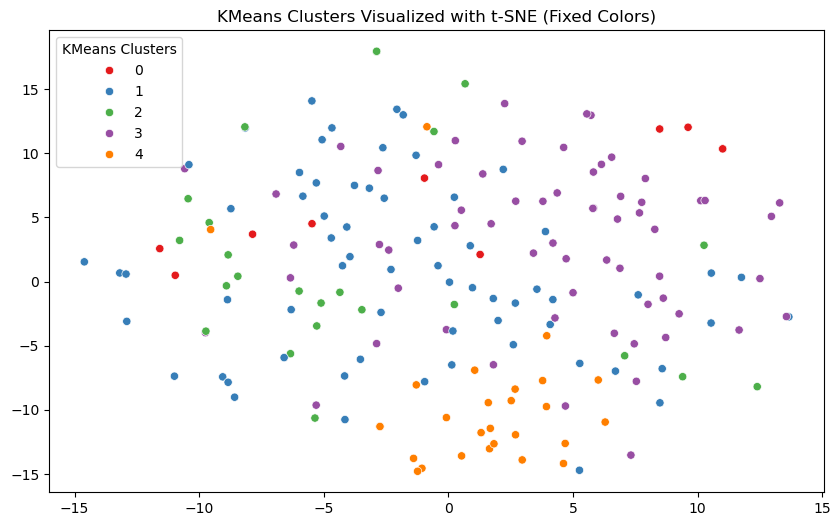

In [13]:
palette = sns.color_palette("Set1", n_colors=n_kmeans)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=kmeans_tsne[:, 0], y=kmeans_tsne[:, 1], hue=df['KMeans_Cluster'], palette=palette, legend='full')
plt.title("KMeans Clusters Visualized with t-SNE (Fixed Colors)")
plt.legend(title="KMeans Clusters")
plt.show()

# 3. Quantos Clusters você utilizou? 

Utilizei **5** clusters para o KMeans.

# 4. Qual relação entre os clusters você acha que existe?

Os clusters de hinos podem ter sido formados com base em alguns fatores principais:

1. **Cultura e História**: Hinos de países com histórias semelhantes, como lutas por independência ou reconstrução, podem compartilhar temas de liberdade e orgulho nacional.
   
2. **Geografia**: Países próximos ou com tradições e línguas em comum podem ter hinos similares, o que influencia os agrupamentos.

3. **Temática**: Alguns hinos destacam religião, patriotismo, natureza ou unidade do povo, o que também pode diferenciar os clusters.

4. **Linguagem e Vocabulário**: A frequência de palavras específicas, como "liberdade" ou "pátria", pode ter impactado a formação dos grupos.

# 5. Aplique Clusterização Hierárquica nos dados.

In [14]:
Z = linkage(tfidf_matrix.toarray(), method='ward')

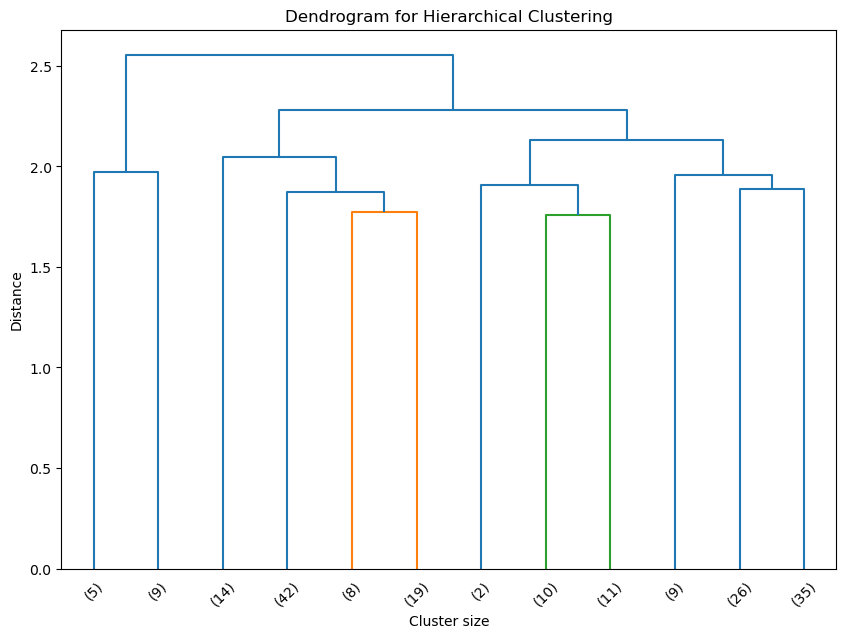

In [15]:
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45, leaf_font_size=10) # truncar dados para gráfico ficar mais visível
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Cluster size")
plt.ylabel("Distance")
plt.show()

In [16]:
n_hierarc = 5
palette = sns.color_palette("Set1", n_colors=n_hierarc)
hierarchical_clusters = fcluster(Z, t=n_hierarc, criterion='maxclust')

In [17]:
df['Hierarchical_Cluster'] = hierarchical_clusters

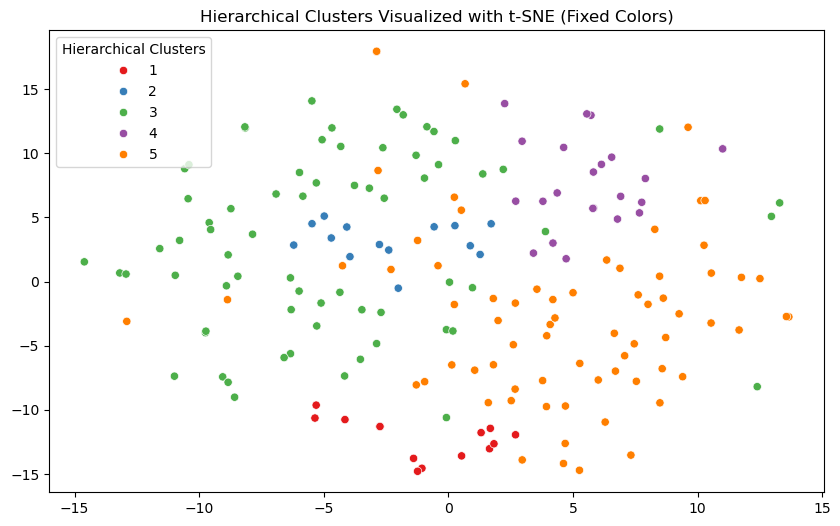

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=kmeans_tsne[:, 0], y=kmeans_tsne[:, 1], hue=df['Hierarchical_Cluster'], palette=palette, legend='full')
plt.title("Hierarchical Clusters Visualized with t-SNE (Fixed Colors)")
plt.legend(title="Hierarchical Clusters")
plt.show()

#### a) Quantos clusters utilizou?

Utilizei **5** clusters para o KMeans.

#### b) Notou alguma diferença entre o KMeans?

A organização e o número de pontos em cada cluster mudaram entre o KMeans e a clusterização hierárquica. O **KMeans** agrupa os hinos de forma rígida, usando uma métrica de distância para definir clusters fixos. Já a **clusterização hierárquica** constrói uma estrutura gradual, permitindo visualizar a formação dos clusters através do dendrograma e fazer cortes em diferentes níveis, o que possibilita uma análise mais flexível e visual dos grupos.

#### c) Qual método de linkage você utilizou? 

O método de linkage utilizado foi o **ward**, que minimiza a variância dentro dos clusters.

# 6. Você conseguiria aplicar DBScan no modelo anterior? Justifique.

Sim, é possível aplicar o **DBScan** no modelo anterior, mas pela natureza dos dados não é muito recomendado.

O DBScan é baseado em **densidade de dados**. Datasets com alta dimensionalidade (como o TF-IDF) não são os ideais para seu uso por conta possibilidade de criação de clusters muito pequenos ou com muito ruído, o que diminui bastante a eficiência da clusterização.

# 7. Aplique O LDA nos hinos.

In [21]:
n_topics = 5

lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [24]:
lda_topics = lda_model.transform(tfidf_matrix)
df['LDA_Topic'] = lda_topics.argmax(axis=1)

/tmp/ipykernel_1582/3828551918.py:3: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x=kmeans_tsne[:, 0], y=kmeans_tsne[:, 1], hue=df['LDA_Topic'], palette=palette, legend='full')


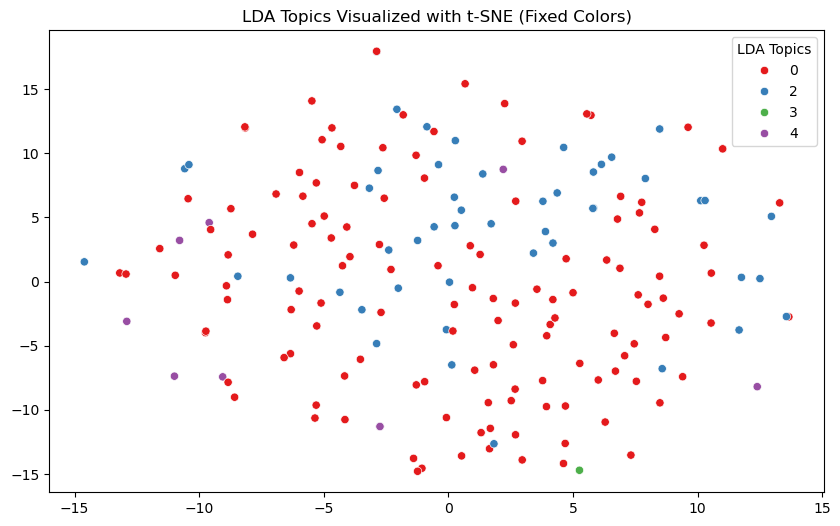

In [25]:
palette = sns.color_palette("Set1", n_colors=n_topics)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=kmeans_tsne[:, 0], y=kmeans_tsne[:, 1], hue=df['LDA_Topic'], palette=palette, legend='full')
plt.title("LDA Topics Visualized with t-SNE (Fixed Colors)")
plt.legend(title="LDA Topics")
plt.show()

# 8. Quantos tópicos utilizou? Mostre os tópicos encontrados.
Utilizei **5** clusters para o KMeans.

In [22]:
def display_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    return topics

In [23]:
n_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
lda_topics = display_topics(lda_model, tf_feature_names, n_top_words)
lda_topics

['Topic 1: land, may, us, thy, god, love, thee, oh, glory, free',
 'Topic 2: invader, path, ones, splendid, flame, arabs, raised, white, follow, supreme',
 'Topic 3: us, let, people, country, one, fatherland, freedom, always, land, forever',
 'Topic 4: thousand, grow, reign, may, splendid, independence, echo, rises, flame, arabs',
 'Topic 5: homeland, hail, home, liberty, arms, die, law, fire, glory, warrior']

# 9. Você consegue achar alguma relação entre os Tópicos selecionados? Se sim, qual?

Sim, é possível identificar algumas relações entre os tópicos encontrados:

1. **Patriotismo e Religião** (Topic 1 e Topic 5): Termos como *thy*, *god*, *glory*, *homeland*, e *liberty* sugerem um forte sentimento de patriotismo, frequentemente associado à devoção religiosa e ao amor pela pátria.

2. **Lutas e Resistência** (Topic 2 e Topic 5): Palavras como *invader*, *flame*, *arms*, *die*, e *warrior* indicam temas relacionados à luta e à defesa da pátria, sugerindo resistência contra invasores ou opressores.

3. **Unidade e Liberdade** (Topic 3): Termos como *us*, *let*, *people*, *freedom*, e *country* destacam a ideia de unidade nacional e busca pela liberdade, temas comuns em hinos.

4. **Independência e Crescimento** (Topic 4): Palavras como *independence*, *grow*, *reign*, e *echo* sugerem um foco na independência do país e no seu crescimento ou prosperidade futura.

Esses tópicos refletem temas comuns em hinos, como patriotismo, lutas por liberdade, unidade nacional e a importância da independência.

# 10. Aplique NMF. Imprima os tópicos.

In [26]:
n_topics_nmf = 5

nmf_model = NMF(n_components=n_topics_nmf, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

In [27]:
display_topics(nmf_model, tf_feature_names, n_top_words)

['Topic 1: let, us, arise, one, people, sing, happiness, unity, africa, proud',
 'Topic 2: thy, thee, thou, hail, thine, ever, liberty, art, prevail, love',
 'Topic 3: fatherland, shall, arms, freedom, liberty, glory, world, war, blood, people',
 'Topic 4: land, may, bless, free, god, oh, love, stand, peace, protect',
 'Topic 5: country, homeland, live, flag, long, glory, king, may, symbol, light']

In [28]:
df['NMF_Topic'] = nmf_topics.argmax(axis=1)

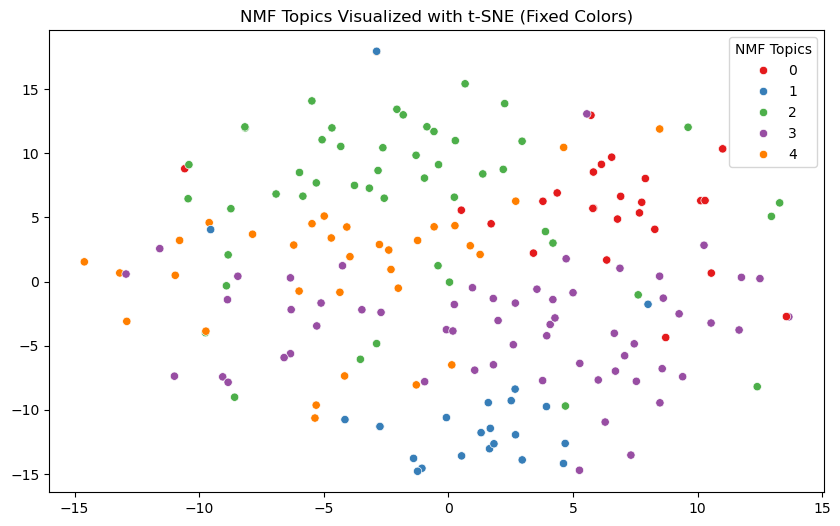

In [29]:
palette = sns.color_palette("Set1", n_colors=n_topics_nmf)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=kmeans_tsne[:, 0], y=kmeans_tsne[:, 1], hue=df['NMF_Topic'], palette=palette, legend='full')
plt.title("NMF Topics Visualized with t-SNE (Fixed Colors)")
plt.legend(title="NMF Topics")
plt.show()

# 11. Notou alguma diferença entre LDA e MNF?

Há algumas diferenças entre os tópicos gerados por **LDA** e **NMF**:

1. **LDA** tende a capturar **tópicos mais distintos** tematicamente, com uma leve sobreposição entre eles. Os tópicos são mais amplos, com uma combinação de palavras que sugerem temas amplos, como *invader*, *warrior*, e *glory* (relacionados à luta), ou *thy*, *god*, e *thee* (patriotismo e religião).

2. **NMF** apresenta **tópicos mais nítidos** e com menos sobreposição. Cada tópico tem uma identidade mais clara. Por exemplo, o **Topic 1** do NMF é focado em unidade e orgulho (*arise*, *people*, *unity*, *africa*), enquanto o **Topic 5** foca no símbolo da pátria e glória nacional (*country*, *flag*, *glory*, *king*).

Essencialmente, o **LDA** captura uma mistura mais fluida de temas, enquanto o **NMF** oferece tópicos mais definidos e específicos.

# 12. Explique o objetivo principal do t-SNE e como ele diferencia de técnicas de redução de dimensionalidade como PCA (Principal Component Analysis).

O t-SNE tem como objetivo principal reduzir a dimensionalidade dos dados, mantendo os pontos que são parecidos próximos uns dos outros em um espaço de menor dimensão (2D ou 3D, geralmente). É muito usado para visualizar dados complexos, como textos ou imagens, de forma que pontos parecidos continuem juntos e os diferentes fiquem afastados.

- PCA é um método linear que reduz a dimensionalidade mudando os dados para novos eixos (projeções em componentes principais), focando em manter a variância total dos dados. Ou seja, ele tenta manter as principais variações, mas não necessariamente as relações de proximidade entre os pontos.

- t-SNE, por outro lado, é um método não linear que tenta preservar as relações de proximidade local entre os pontos. Ele calcula a similaridade entre os pontos e tenta manter pontos próximos no espaço original também próximos no espaço reduzido.

# 13. Suponha que você tenha um conjunto de dados com 1000 características e deseja visualizá-lo em 2 dimensões usando t-SNE. Descreva os principais passos do processo de aplicação do t-SNE, incluindo como ele preserva a estrutura dos dados e quais são as possíveis saídas ou resultados que você espera obter após a aplicação do t-SNE.

Principais passos
1. Calcula-se as similaridades entre os pontos no espaço de alta dimensão.
2. Mapeia-se os dados para o espaço de 2D.
3. Minimiza-se a diferença entre as similaridades nos dois espaços.
4. O resultado é um gráfico em 2D onde pontos próximos no gráfico representam dados semelhantes.

Exemplo

```python
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(data)

plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.title('t-SNE Visualization')
plt.show()
```

# 14. O que é o parâmetro "perplexidade" no contexto do t-SNE, e como ele afeta o resultado da redução de dimensionalidade? Explique seu impacto na construção do gráfico de similaridade dos dados.

A **perplexidade** no t-SNE controla quantos vizinhos são considerados para calcular as similaridades. 

- **Baixa perplexidade** (~5-30): foca nas relações locais, criando clusters pequenos e bem separados.
- **Alta perplexidade** (>30): foca nas relações globais, resultando em clusters maiores e menos separados.

Ela equilibra a preservação de detalhes locais e globais. Valores típicos variam entre 5 e 50.

# 15. Se você observar que os dados resultantes após a aplicação do t-SNE estão agrupados em clusters bem definidos, mas algumas áreas do gráfico possuem uma alta densidade de pontos que parecem sobrepostos ou distorcidos, o que isso pode indicar sobre a configuração dos parâmetros do t-SNE? O que você poderia ajustar para melhorar a visualização e a interpretação dos clusters?

Se os dados resultantes do t-SNE estão formando **clusters bem definidos**, mas algumas áreas apresentam alta densidade ou sobreposição de pontos, isso pode indicar que alguns parâmetros do t-SNE não estão adequados para os dados. Aqui estão possíveis causas e ajustes:

### Possíveis Causas:
1. **Perplexidade inadequada**: Se a perplexidade for muito baixa ou alta, pode não estar balanceando bem as relações locais e globais, levando à sobreposição de pontos.
   
2. **Taxa de aprendizado (learning rate)**: Um valor de taxa de aprendizado muito alto ou baixo pode causar distorções ou dificuldade em encontrar uma representação clara dos dados.

### Ajustes para melhorar:
1. **Ajustar a perplexidade**: Tente variar a perplexidade dentro da faixa comum (5-50) para ver se a distribuição melhora. Pequenos clusters podem se beneficiar de valores mais baixos; clusters mais amplos podem exigir valores mais altos.
   
2. **Alterar a taxa de aprendizado**: Modificar a taxa de aprendizado, geralmente testando valores entre 10 e 1000, pode ajudar a ajustar o processo de otimização para melhor separar os pontos.

### Resumo:
- **Perplexidade**: Ajustar para equilibrar relações locais e globais.
- **Taxa de aprendizado**: Testar diferentes valores para evitar distorções ou sobreposições.